In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import numpy as np
from glob import glob

tf.enable_eager_execution()
tfe = tf.contrib.eager

In [2]:
def _parse_function(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize_image_with_crop_or_pad(image_decoded, target_height=180, target_width=280)
    image_resized = tf.cast(image_resized, dtype=tf.float32)
    return image_resized

# create image dataset from image file names
img_files = tf.constant(glob('img_dataset/*.jpg'))
dataset = tf.data.Dataset.from_tensor_slices(img_files)
dataset = dataset.map(_parse_function)

# since we have a small number of pictures, our dataset will 
# just be a single batch of all five images
dataset = dataset.shuffle(buffer_size=5).repeat(1).batch(5)

In [18]:
def make_img_grid(img_tensor, n_rows, n_cols, img_height, img_width, img_channel):
    # display the conv2d maps
    img_grid = tf.contrib.gan.eval.image_grid(
                    input_tensor=img_tensor,
                    grid_shape=(n_rows,n_cols),
                    image_shape=(img_height, img_width),
                    num_channels=img_channel
                )
    return img_grid

---
## 1. Conv2D-Transpose Operation

Conv2D-transpose is the reverse operation of a conv2d operation:

*"The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution."*



In [16]:
# forward convolution from a batch of image
for img in dataset:
    # convolution operation
    conv2d_same_pad  = tf.layers.conv2d(inputs=img, filters=5, kernel_size=4, strides=5, padding='same')    

print('input tensor shape: ', img.shape)
print('output tensor shape from the conv2D operation: ', conv2d_same_pad.shape)

input tensor shape:  (5, 180, 280, 3)
output tensor shape from the conv2D operation:  (5, 36, 56, 5)


In [17]:
# reverse convolution (transposed) from resultant shape back to batch image tensor dimensions
input_z = np.random.normal(size=(5,36,56,5))
input_z = tf.convert_to_tensor(input_z)
conv2d_transpose_same_pad = tf.layers.conv2d_transpose(inputs=input_z, filters=5, kernel_size=4, strides=5, padding='same')    

print('input tensor shape: ', input_z.shape)
print('output tensor shape from the conv2D transpose operation: ', conv2d_transpose_same_pad.shape)

input tensor shape:  (5, 36, 56, 5)
output tensor shape from the conv2D transpose operation:  (5, 180, 280, 5)


The images below illustrates the resulting image grid from the conv2D transpose operation. The input tensor is randomly generated from a normal distribution and the conv2d kernels have no training, so the actualy output of the images are not interesting (they are just noise), but the key point is that the output tensor shape from conv2d_transpose is exactly the same as the input image batch to a conv2d operation.

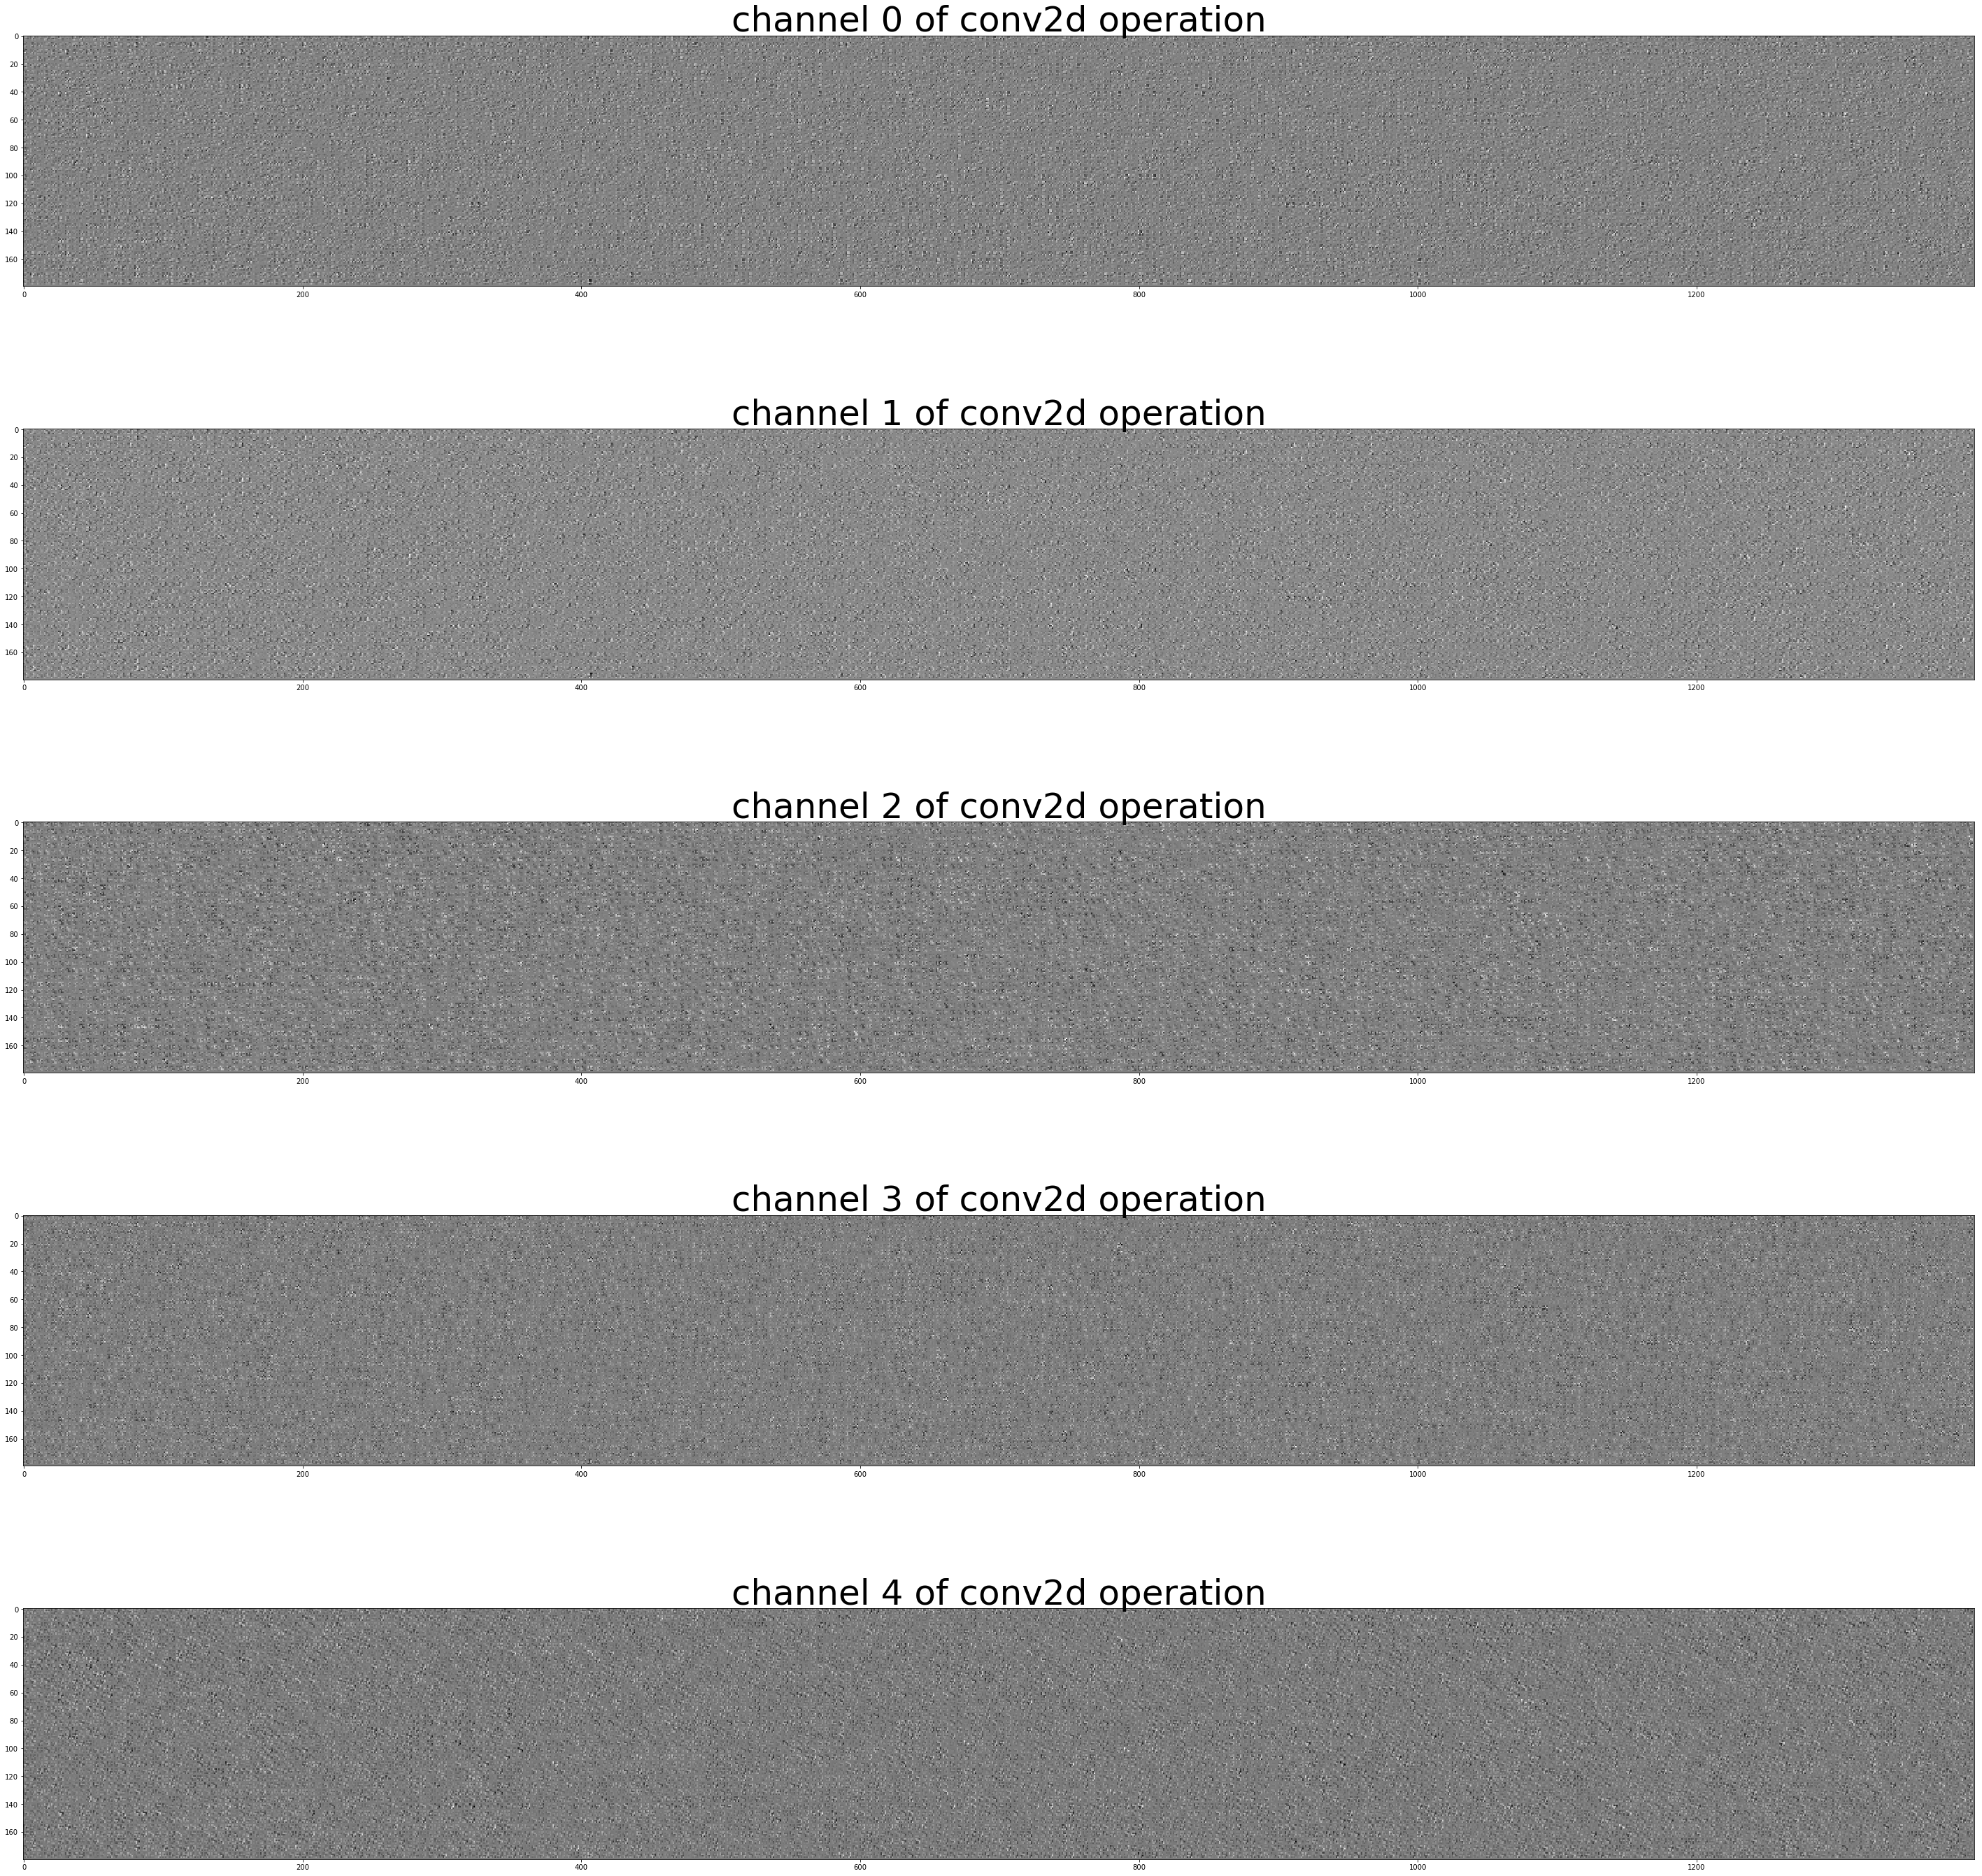

In [25]:
img_grid = make_img_grid(conv2d_transpose_same_pad, 1, 5, 180, 280, 5)
channels = 5
plt.figure(figsize=(50,50))
for i in range(channels):
    plt.subplot(channels,1,i+1)
    plt.imshow(img_grid.numpy()[0,:,:,i], cmap='gray')
    plt.title('channel {} of conv2d operation'.format(i), fontsize=50)
plt.show()